In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.applications import MobileNetV2
from keras.optimizers import Adam

# Set the path to data folder
fer2013 = '/Users/engr/Desktop/FER'

train = '/Users/engr/Desktop/FER/train'

test = '/Users/engr/Desktop/FER/test'

The necessary libraries are imported.

The paths to the data folders are set.

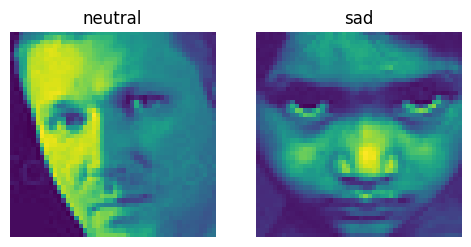

Train Folder:
neutral: 4966 images
sad: 4831 images

Test Folder:
sad: 1247 images
neutral: 1233 images


In [29]:
# Function to display one image from each class
def display_one_image(class_name, index):
    img_path = os.path.join(fer2013, "train", class_name, 
                            os.listdir(os.path.join(fer2013, "train", class_name))[10])
    img = Image.open(img_path)
    plt.subplot(1, num_cols, index)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

# Set the number of columns based on the number of classes
num_cols = min(len(os.listdir(os.path.join(fer2013, "train"))), 8)

# Set up the grid
plt.figure(figsize=(9, 3))
[display_one_image(class_name, i + 1) for i, class_name in 
 enumerate(sorted([dir for dir in os.listdir(os.path.join(fer2013, "train")) 
 if os.path.isdir(os.path.join(fer2013, "train", dir)) and dir != '.DS_Store']))]

plt.show()

# Function to get the number of images in each folder
def get_image_counts(folder):
    return {class_name: len(os.listdir(os.path.join(fer2013, folder, class_name))) 
            for class_name in sorted([dir for dir in os.listdir(os.path.join(fer2013, folder)) 
            if os.path.isdir(os.path.join(fer2013, folder, dir)) and dir != '.DS_Store'])}

# Display the number of images from the "train" folder in descending order
print("Train Folder:")
train_counts = sorted(get_image_counts("train").items(), key=lambda x: x[1], reverse=True)
for class_name, num_images in train_counts:
    print(f"{class_name}: {num_images} images")

# Display the number of images from the "test" folder in descending order
print("\nTest Folder:")
test_counts = sorted(get_image_counts("test").items(), key=lambda x: x[1], reverse=True)
for class_name, num_images in test_counts:
    print(f"{class_name}: {num_images} images")


The display_one_image function takes a class name and an index, then displays the 10th image from that class in the training set.

It uses Matplotlib to create a subplot for each class and displays the image with the class name as the title.

The function is applied to each class, and the resulting grid of images is shown using plt.show().


The get_image_counts function returns a dictionary with class names as keys and the number of images in each class in a specified folder (either "train" or "test").

The script then prints the number of images in each class in the "train" and "test" folders, sorted in descending order by the number of images.


In [30]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Preprocessing 

# Define batch size
batch_size = 32

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(48, 48),
    batch_size=batch_size,
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(48, 48),
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale',
    class_mode='categorical'
)


Found 9795 images belonging to 2 classes.
Found 2480 images belonging to 2 classes.


train_datagen is set up for data augmentation on training images. It includes various transformations like rotation, shearing, zooming, horizontal flipping, and random shifts.

test_datagen is used for rescaling only, without augmentation. This is typical as data augmentation is generally not applied to test/validation sets.


The batch size is defined as 32, which is the number of samples processed in each iteration during training.

train_generator and test_generator are set up to flow images from the specified directories. This is crucial for handling large datasets that might not fit into memory.

target_size sets the dimensions to which all images will be resized during the flow.

shuffle is set to True for the training generator, meaning the order of the training data is shuffled after each epoch for better learning. 
For the test generator, it's set to False.

color_mode is set to 'grayscale', indicating that the images are read as grayscale.

class_mode is set to 'categorical', which is suitable for multiclass classification problems.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 4, 4, 128)        

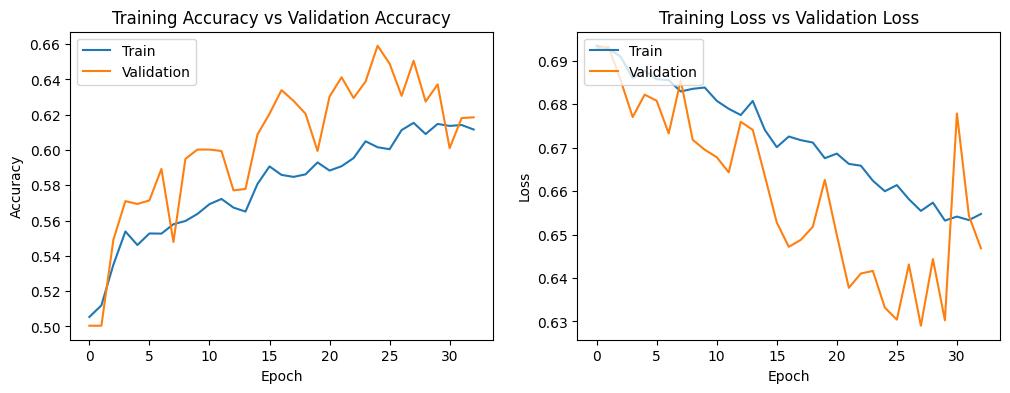

In [31]:
# Building the CNN model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping]
)

# Save the model
model.save('/Users/engr/Desktop/FER2013/my_model.keras')

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

The model consists of a series of convolutional layers (Conv2D) followed by max-pooling layers (MaxPooling2D).

The final layers include a flatten layer to convert the 2D feature maps to a 1D vector, followed by fully connected layers (Dense) for classification.

The activation functions used are ReLU for the convolutional layers and softmax for the final output layer

Early stopping is implemented to prevent overfitting. Training will stop if the validation loss does not improve for 5 consecutive epochs, and the best weights are restored.

The model is trained using the fit method with the specified generators for training and testing. The training is monitored by the early stopping callback.

Matplotlib is used to create a subplot with two plots: one for accuracy and one for loss.
The training and validation accuracy/loss are plotted over epochs to visualize the model's learning progress.

77/77 [==============================] - 1s 14ms/step - loss: 0.6290 - accuracy: 0.6506

Test Accuracy: 65.06%
78/78 [==============================] - 1s 13ms/step

Classification Report:
              precision    recall  f1-score   support

     neutral       0.62      0.74      0.68      1233
         sad       0.69      0.56      0.62      1247

    accuracy                           0.65      2480
   macro avg       0.65      0.65      0.65      2480
weighted avg       0.65      0.65      0.65      2480

Confusion Matrix:
[[913 320]
 [550 697]]


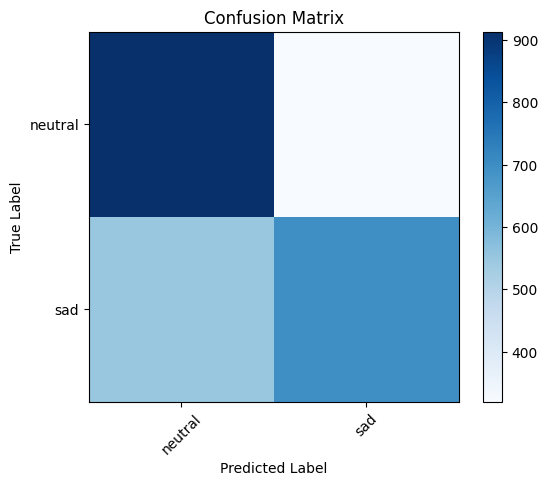

In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'\nTest Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names, zero_division=0))

print("Confusion Matrix:")
conf_mat = confusion_matrix(y_true, y_pred_classes)
print(conf_mat)

# Plot confusion matrix
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


The model is evaluated on the test set using the evaluate method. The test loss and accuracy are printed

Model predictions are obtained using the predict method on the test generator.
The predicted class labels are extracted using np.argmax.
True class labels (y_true) and class names (class_names) are also obtained from the test generator.

The classification_report function from scikit-learn is used to print precision, recall, and F1-score for each class, as well as overall metrics.

The confusion matrix is printed using confusion_matrix.
The plot provides a visual representation of the model's performance on the test set.
